# Time filter

In [400]:
import time
import numpy as np
import struct
from scapy.all import rdpcap
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Load .pcap data

In [401]:
pcap_path = '../data/late_z_and_p_test.pcap'
# pcap_path = '../data/zelzah_plummer_intersection_12min_032023_lidar.pcap'

In [402]:
packets = rdpcap(pcap_path)

## VLC 32c calibration data

In [403]:
raw_calib_data = [
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -25},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -1},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -1.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -15.639},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -11.31},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 0},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -0.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -8.843},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -7.254},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': 0.333},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -0.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -6.148},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -5.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 1.333},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': 0.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -4},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -4.667},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': 1.667},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 1},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -3.667},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -3.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 3.333},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 2.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -2.667},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -3},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 7},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 4.667},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -2.333},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -2},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 15},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 10.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -1.333},
]

In [404]:
# Laser ID mapping for VLP-32C
laser_id_mapping = np.array([
    15, 14, 13, 12, 11, 10, 9, 8,
    7, 6, 5, 4, 3, 2, 1, 0,
    31, 30, 29, 28, 27, 26, 25, 24,
    23, 22, 21, 20, 19, 18, 17, 16
])

In [405]:
# # Laser firing order based on the manual
# laser_firing_order = [
#     (0, 1),   # Firing 0
#     (2, 3),   # Firing 1
#     (4, 5),   # Firing 2
#     (6, 7),   # Firing 3
#     (8, 9),   # Firing 4
#     (10, 11), # Firing 5
#     (12, 13), # Firing 6
#     (14, 15), # Firing 7
#     (16, 17), # Firing 8
#     (18, 19), # Firing 9
#     (20, 21), # Firing 10
#     (22, 23), # Firing 11
#     (24, 25), # Firing 12
#     (26, 27), # Firing 13
#     (28, 29), # Firing 14
#     (30, 31), # Firing 15
# ]

# # Flatten the list to get the laser_id_mapping
# laser_id_mapping = [laser_id for pair in laser_firing_order for laser_id in pair]
# print(laser_id_mapping)

In [406]:
focal_distance = 42.4e-3

In [407]:
laser_corrections = []

for i, calib in enumerate(raw_calib_data):
    rot_corr_deg = calib['rot_corr_deg']
    vert_corr_deg = calib['vert_corr_deg']
    rot_correction = np.deg2rad(rot_corr_deg)
    vert_correction = np.deg2rad(vert_corr_deg)
    # Compute vertical offset correction
    vert_offset_correction = focal_distance * np.tan(-vert_correction)
    laser_corrections.append({
        'laser_idx': i,
        'rot_correction': rot_correction,
        'vert_correction': vert_correction,
        'vert_offset_correction': vert_offset_correction
    })
    
print(list(laser_corrections[0])[:4])

['laser_idx', 'rot_correction', 'vert_correction', 'vert_offset_correction']


In [408]:
# def build_timing_offsets():
#     full_firing_cycle = 55.296  # microseconds
#     single_firing = 2.304       # microseconds
#     timing_offsets = np.zeros((12, 32))  # 12 blocks, 32 measurements per block
#     for block_idx in range(12):
#         for measurement_idx in range(32):
#             firing_index = measurement_idx // 2
#             timing_offsets[block_idx, measurement_idx] = (
#                 full_firing_cycle * block_idx + single_firing * firing_index
#             )
#     return timing_offsets  # in microseconds

In [409]:
def build_timing_table(dual_mode=False):
    full_firing_cycle = 55.296  # μs
    single_firing = 2.304       # μs
    num_sequences = 12
    num_firings_per_sequence = 16
    num_data_points_per_sequence = 32  # 32 lasers (16 firings x 2)

    timing_offsets = np.zeros((num_sequences, num_data_points_per_sequence))  # Shape: (12, 32)

    for seq_idx in range(num_sequences):  # SequenceIndex from 0 to 11
        for dp_idx in range(num_data_points_per_sequence):  # DataPointIndex from 0 to 31
            firing_index = dp_idx // 2  # Each firing consists of two lasers
            time_offset = (full_firing_cycle * seq_idx) + (single_firing * firing_index)
            timing_offsets[seq_idx, dp_idx] = time_offset
    return timing_offsets  # in μs


## Packet parsing functions

In [410]:
def calculate_rotation_rate(blocks, timing_offsets):
    first_azimuth = blocks[0]['azimuth']
    last_azimuth = blocks[-1]['azimuth']
    total_time_diff = (timing_offsets[-1, -1] - timing_offsets[0, 0]) / 1e6  # Convert μs to seconds

    # Handle azimuth wrap-around
    azimuth_diff = (last_azimuth - first_azimuth) % 360.0
    if azimuth_diff > 180:
        azimuth_diff -= 360.0  # Choose the shortest rotation direction

    if total_time_diff == 0:
        rotation_rate = 0
    else:
        rotation_rate = azimuth_diff / total_time_diff  # degrees per second

    return rotation_rate


In [411]:
def parse_packet(data):
    # Extract timestamp and factory bytes from the last 6 bytes
    stamp, factory = struct.unpack_from('<IH', data, offset=len(data) - 6)
    timestamp = stamp / 1e6  # Convert microseconds to seconds
    
    blocks = []
    offset = 0
    for _ in range(12):  # 12 blocks per packet
        # Read block ID as big-endian, azimuth as little-endian
        block_id = struct.unpack_from('>H', data, offset)[0]
        offset += 2
        azimuth = struct.unpack_from('<H', data, offset)[0]
        offset += 2
        if block_id != 0xFFEE:
            print(f"Invalid block ID: {hex(block_id)} at offset {offset}")
            offset += 96  # Skip rest of the block (32 measurements * 3 bytes)
            continue  # Skip invalid block
        # Measurements
        measurements = []
        for _ in range(32):  # 32 measurements per block
            distance, reflectivity = struct.unpack_from('<HB', data, offset)
            offset += 3
            measurements.append({'distance': distance, 'reflectivity': reflectivity})
        blocks.append({'azimuth': azimuth / 100.0, 'measurements': measurements})
    return blocks, timestamp

In [412]:
# def process_blocks(blocks):
#     points = []
#     for block in blocks:
#         azimuth_deg = block['azimuth']
#         measurements = block['measurements']
#         # Try to do this with vector operations if possible
#         for idx, measurement in enumerate(measurements):
#             laser_id = laser_id_mapping[idx]
#             distance = measurement['distance'] * 0.004  # VLP-32C distance resolution
#             reflectivity = measurement['reflectivity']
#             if distance == 0.0:
#                 continue  # Skip invalid measurements

#             # Get corrections
#             correction = laser_corrections[laser_id]
#             rot_correction = correction['rot_correction']
#             vert_correction = correction['vert_correction']
#             vert_offset_correction = correction['vert_offset_correction']

#             # Adjust azimuth and vertical angle
#             azimuth_rad = np.deg2rad(azimuth_deg) + rot_correction
#             vert_angle_rad = vert_correction

#             # Compute coordinates
#             x = distance * np.cos(vert_angle_rad) * np.sin(azimuth_rad)
#             y = distance * np.cos(vert_angle_rad) * np.cos(azimuth_rad)
#             z = distance * np.sin(vert_angle_rad) + vert_offset_correction

#             point = {
#                 'x': x,
#                 'y': y,
#                 'z': z,
#                 'intensity': reflectivity,
#                 'laser_id': laser_id,
#                 'azimuth': azimuth_deg,
#                 'distance': distance
#             }
#             points.append(point)
#     return points

In [413]:
# def process_blocks(blocks):
#     points = []
#     num_blocks = len(blocks)
#     for block_idx in range(num_blocks):
#         block = blocks[block_idx]
#         azimuth_1 = block['azimuth']  # Azimuth angle for the first firing
#         measurements = block['measurements']

#         # Determine azimuth for the second firing
#         if block_idx < num_blocks - 1:
#             azimuth_3 = blocks[block_idx + 1]['azimuth']
#         else:
#             azimuth_3 = azimuth_1

#         delta_azimuth = (azimuth_3 - azimuth_1) % 360.0
#         if delta_azimuth < 0:
#             delta_azimuth += 360.0

#         # Time offsets in microseconds
#         # Time between blocks: 55.296 µs
#         # Time between firings: 55.296 µs
#         # Time between channels in a firing: 2.665 µs

#         for idx, measurement in enumerate(measurements):
#             laser_id = laser_id_mapping[idx]
#             distance = measurement['distance'] * 0.004  # VLP-32C distance resolution
#             reflectivity = measurement['reflectivity']
#             if distance == 0.0:
#                 continue  # Skip invalid measurements

#             # Get corrections
#             correction = laser_corrections[laser_id]
#             rot_correction = correction['rot_correction']
#             vert_correction = correction['vert_correction']
#             vert_offset_correction = correction['vert_offset_correction']

#             # Calculate time offset
#             # idx ranges from 0 to 31
#             firing_in_block = idx // 16  # 0 for first firing, 1 for second firing
#             laser_in_firing = idx % 16
#             time_since_block_start = firing_in_block * 55.296 + laser_in_firing * 2.665  # in µs

#             # Compute azimuth angle adjustment
#             azimuth_offset = (delta_azimuth * (time_since_block_start / 55.296)) % 360.0

#             # Adjusted azimuth
#             adjusted_azimuth_deg = (azimuth_1 + azimuth_offset) % 360.0

#             # Adjust azimuth and vertical angle
#             azimuth_rad = np.deg2rad(adjusted_azimuth_deg) + rot_correction
#             vert_angle_rad = vert_correction

#             # Compute coordinates
#             x = distance * np.cos(vert_angle_rad) * np.sin(azimuth_rad)
#             y = distance * np.cos(vert_angle_rad) * np.cos(azimuth_rad)
#             z = distance * np.sin(vert_angle_rad) + vert_offset_correction

#             point = {
#                 'x': x,
#                 'y': y,
#                 'z': z,
#                 'intensity': reflectivity,
#                 'laser_id': laser_id,
#                 'azimuth': adjusted_azimuth_deg,
#                 'distance': distance
#             }
#             points.append(point)
#     return points


In [414]:
def process_blocks(blocks, timestamp):
    points = []
    num_blocks = len(blocks)
    timing_offsets = build_timing_table(dual_mode=False)  # Assuming single return mode

    # Calculate rotation rate for the packet
    first_azimuth = blocks[0]['azimuth']
    last_azimuth = blocks[-1]['azimuth']
    azimuth_diff = (last_azimuth - first_azimuth) % 360.0
    total_time_diff = (timing_offsets[-1, -1] - timing_offsets[0, 0]) / 1e6  # Convert μs to seconds
    if total_time_diff == 0:
        rotation_rate = 0
    else:
        rotation_rate = azimuth_diff / total_time_diff  # degrees per second

    for block_idx, block in enumerate(blocks):
        sequence_index = block_idx
        block_azimuth = block['azimuth']  # Azimuth angle for the block
        measurements = block['measurements']

        for idx, measurement in enumerate(measurements):
            laser_id = laser_id_mapping[idx]
            distance = measurement['distance'] * 0.004  # VLP-32C distance resolution
            reflectivity = measurement['reflectivity']
            if distance == 0.0:
                continue  # Skip invalid measurements

            # Get corrections
            correction = laser_corrections[laser_id]
            rot_correction = correction['rot_correction']
            vert_correction = correction['vert_correction']
            vert_offset_correction = correction['vert_offset_correction']

            # Calculate timing offset for the data point
            data_point_index = idx // 2
            time_offset = (55.296 * sequence_index) + (2.304 * data_point_index)  # in μs

            # Calculate exact point time
            exact_point_time = timestamp + (time_offset / 1e6)  # Convert μs to seconds

            # Adjust azimuth angle
            time_since_first_azimuth = (exact_point_time - timestamp)
            adjusted_azimuth_deg = (first_azimuth + rotation_rate * time_since_first_azimuth) % 360.0

            # Apply corrections
            azimuth_rad = np.deg2rad(adjusted_azimuth_deg) + rot_correction
            
            vert_angle_rad = vert_correction

            # Compute coordinates
            x = distance * np.cos(vert_angle_rad) * np.sin(azimuth_rad)
            y = distance * np.cos(vert_angle_rad) * np.cos(azimuth_rad)
            z = distance * np.sin(vert_angle_rad) + vert_offset_correction

            point = {
                'x': x,
                'y': y,
                'z': z,
                'intensity': reflectivity,
                'laser_id': laser_id,
                'azimuth': adjusted_azimuth_deg,
                'distance': distance
            }
            points.append(point)
    return points


In [415]:
AZIMUTH_WRAP_AROUND_THRESHOLD = 350.0  # degrees
AZIMUTH_RESET_THRESHOLD = 10.0  # degrees

In [416]:
def process_pcap_into_frames(packets):
    frames = []
    current_frame = []
    prev_azimuth = None

    for packet in packets:
#         print('.', end='')
        if packet.haslayer('UDP') and packet['UDP'].dport == 2368:
            data = bytes(packet['UDP'].payload)
            result = parse_packet(data)
#             print('after result')
            if result is None:
                continue
            blocks, timestamp = result
            for block in blocks:
                azimuth = block['azimuth']
                # Check for azimuth wrap-around
                if prev_azimuth is not None:
                    if (prev_azimuth > AZIMUTH_WRAP_AROUND_THRESHOLD) and (azimuth < AZIMUTH_RESET_THRESHOLD):
                        # Start a new frame
                        if current_frame:
                            frames.append(current_frame)
                            current_frame = []
                prev_azimuth = azimuth
                # Process block and add points to current frame
                points = process_blocks([block], timestamp)
                current_frame.extend(points)

    # Add the last frame
    if current_frame:
        frames.append(current_frame)

    print(f"Processed {len(frames)} frames.")
    return frames

## Test packet parsing

In [417]:
# packets_test = packets[:1000]
packets_test = packets

In [418]:
test_frames = process_pcap_into_frames(packets_test)
print(f"Total frames: {len(test_frames)}")

Processed 34 frames.
Total frames: 34


In [419]:
for idx, frame in enumerate(test_frames):
    print(f"Frame {idx+1}: {len(frame)} points")

Frame 1: 36084 points
Frame 2: 52508 points
Frame 3: 52552 points
Frame 4: 52510 points
Frame 5: 52519 points
Frame 6: 52527 points
Frame 7: 52552 points
Frame 8: 52502 points
Frame 9: 52464 points
Frame 10: 52501 points
Frame 11: 52480 points
Frame 12: 52459 points
Frame 13: 52503 points
Frame 14: 52474 points
Frame 15: 52492 points
Frame 16: 52370 points
Frame 17: 52541 points
Frame 18: 52439 points
Frame 19: 52422 points
Frame 20: 52458 points
Frame 21: 52454 points
Frame 22: 52445 points
Frame 23: 52523 points
Frame 24: 52432 points
Frame 25: 52518 points
Frame 26: 52518 points
Frame 27: 52426 points
Frame 28: 52545 points
Frame 29: 52496 points
Frame 30: 52552 points
Frame 31: 52442 points
Frame 32: 52539 points
Frame 33: 52510 points
Frame 34: 25705 points


In [420]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [421]:
frame_index = 3  # Index of the frame to plot
test_x = [point['x'] for point in test_frames[frame_index]]
test_y = [point['y'] for point in test_frames[frame_index]]
test_z = [point['z'] for point in test_frames[frame_index]]
intensities = [point['intensity'] for point in test_frames[frame_index]]

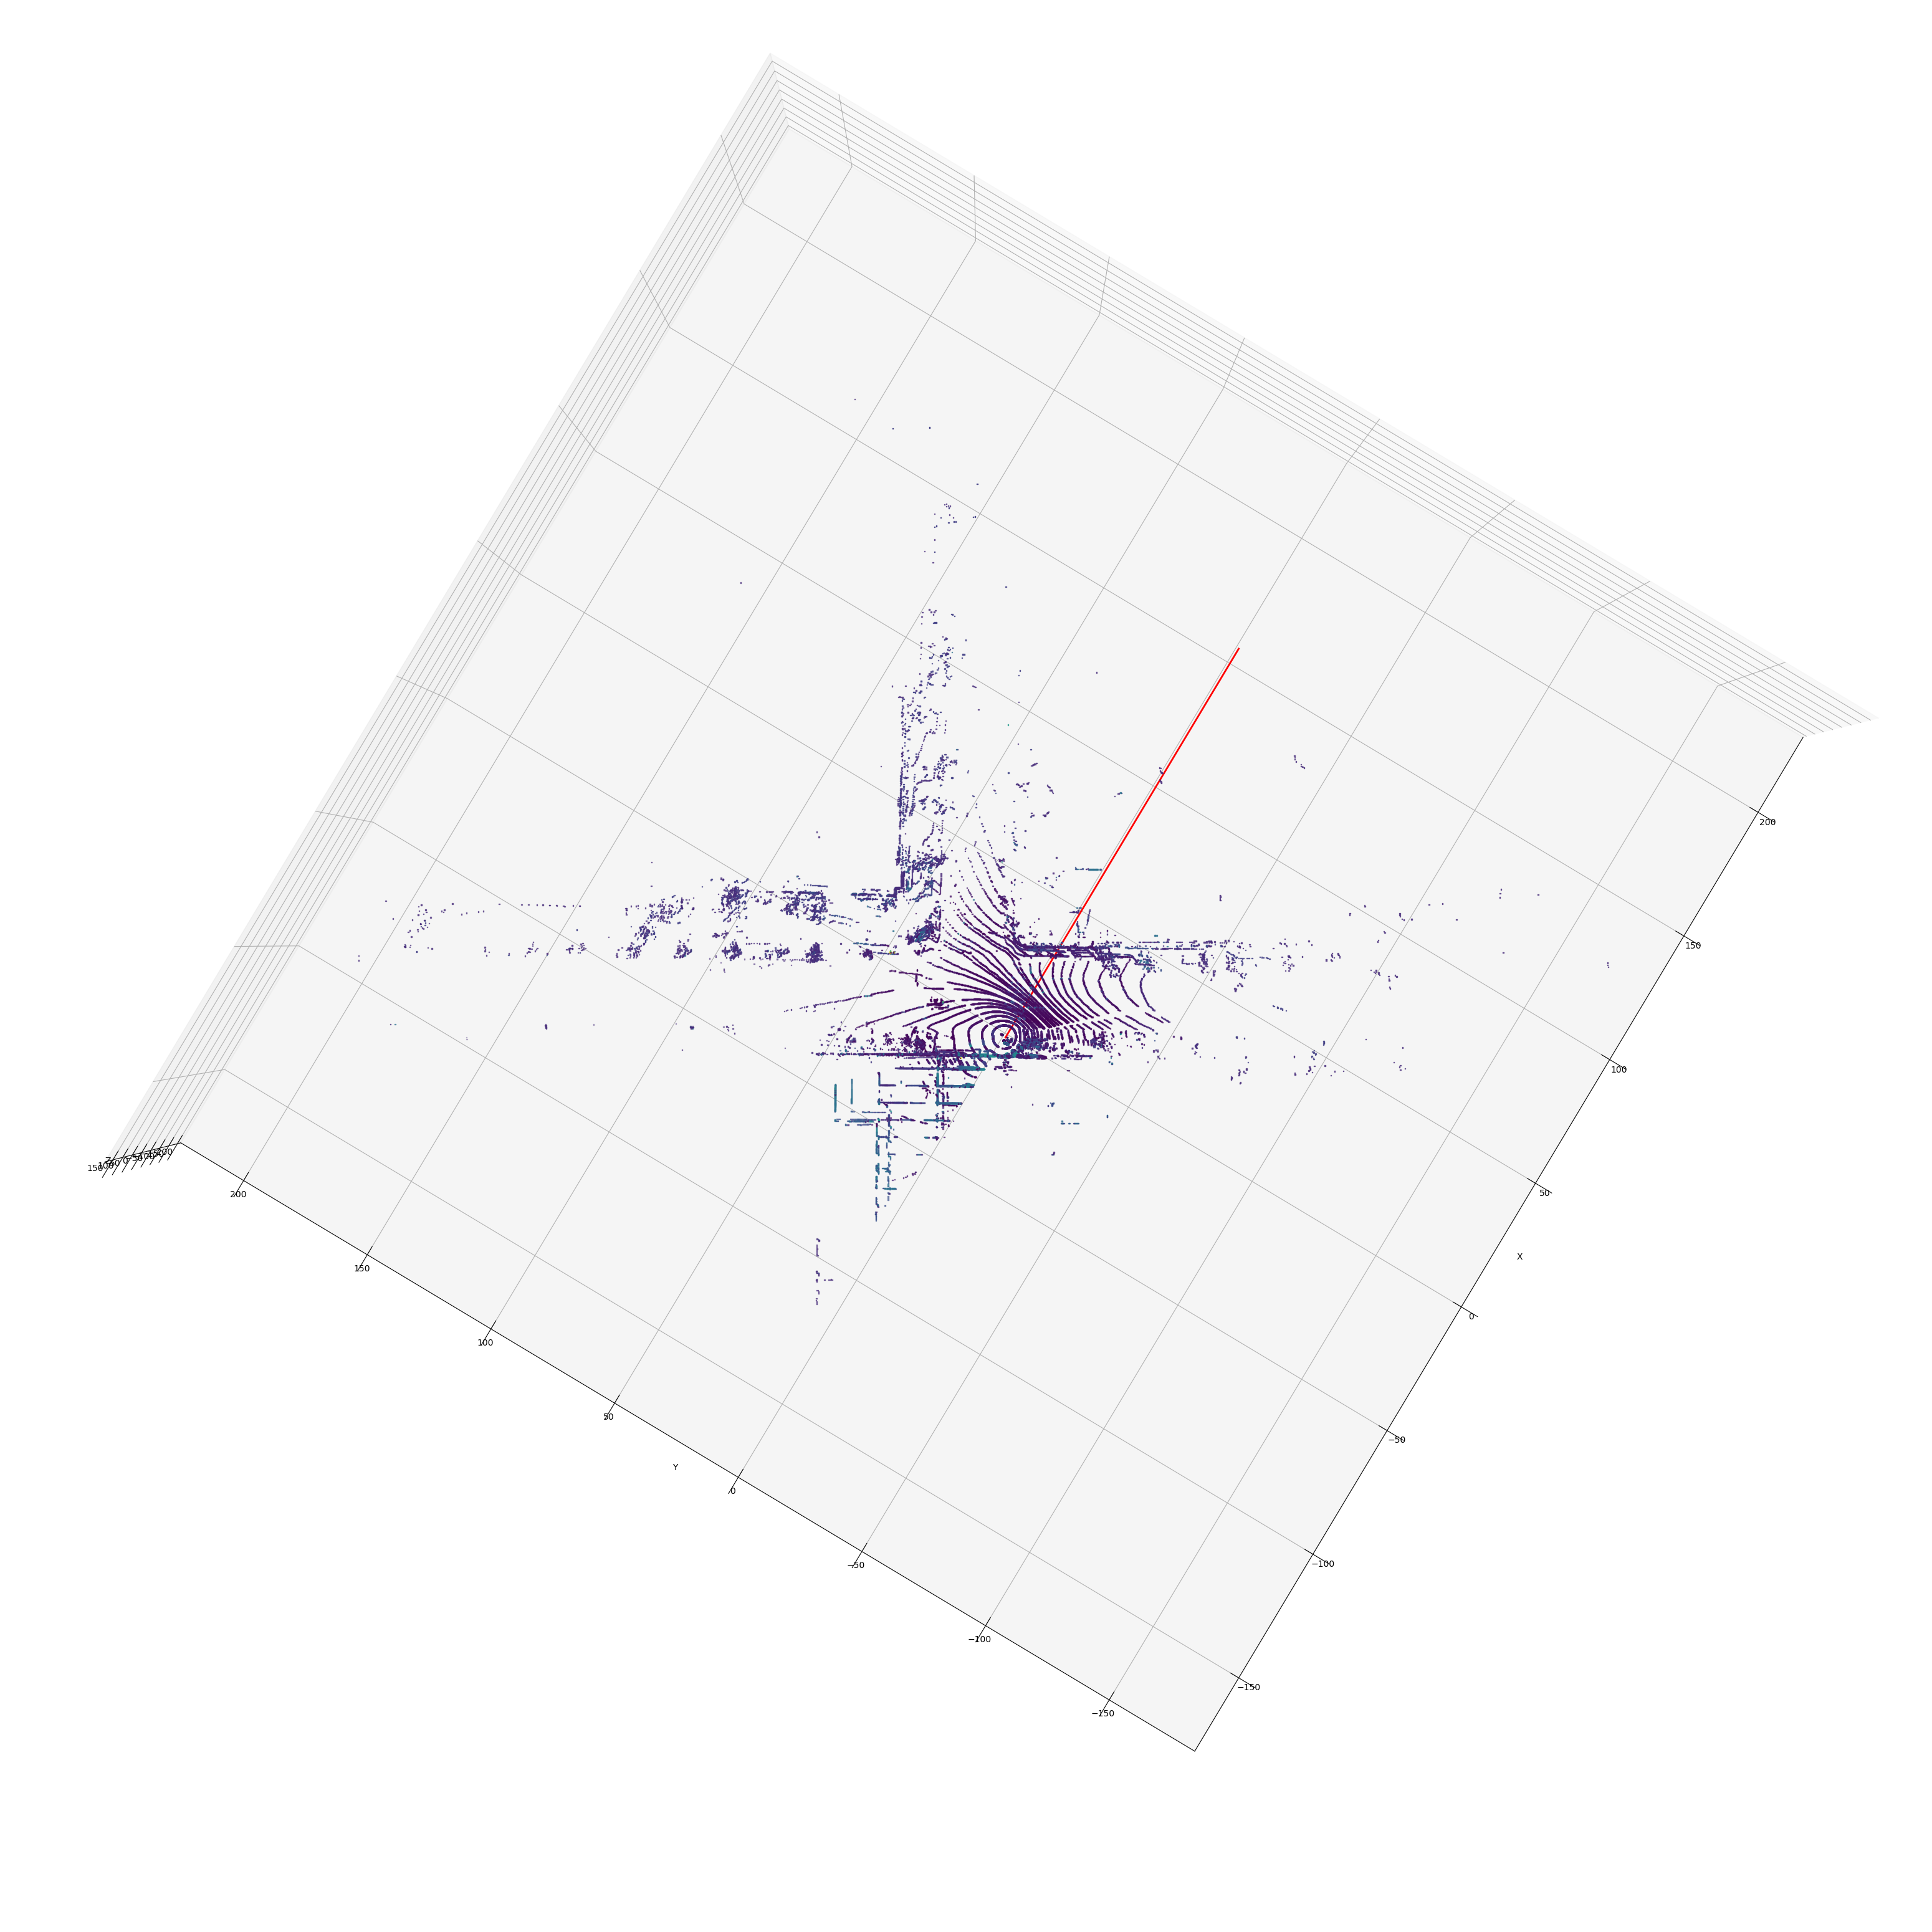

In [422]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(test_x, test_y, test_z, c=intensities, s=1, cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add the line from (0, 0, 0) to (70, 0, 0) in the 0-degree azimuth direction
start_point = [0, 0, 0]  # Starting point (0, 0, 0)
end_point = [150, 0, 0]   # Ending point (70, 0, 0)

# Plot the line
ax.plot([start_point[0], end_point[0]],  # X coordinates
        [start_point[1], end_point[1]],  # Y coordinates
        [start_point[2], end_point[2]],  # Z coordinates
        color='red', linewidth=2) 

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()

In [423]:
# How accurate are azimuth angles?
frame_index = 4  # Index of the frame to plot
azimuths = [point['laser_id'] for point in test_frames[frame_index]]
print(set(azimuths))
print(len(set(azimuths)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
32


The azimuths only go to two decimal places, so I can just make a grid from 0-359.99

## Make filter

In [424]:
# If false, load previously calculated lookup table
make_new_lookup_table = True

In [425]:
# This lookup table is a lot simpler and doesn't need binning
def create_lookup_table():
    num_laser_ids = 32        # Laser IDs from 0 to 31
    num_azimuth_indices = 36000  # Azimuth indices from 0 to 35999 (0.00 to 359.99 degrees multiplied by 100)
    # Initialize the lookup table with zeros or any default value
    lookup_table = np.zeros((num_laser_ids, num_azimuth_indices), dtype=np.float32)
    return lookup_table

In [426]:
def vectorized_update_lookup_table(frame, lookup_table):
    # Convert points to NumPy arrays
    laser_ids = np.array([point['laser_id'] for point in frame], dtype=np.int32)
    azimuth_degs = np.array([point['azimuth'] for point in frame], dtype=np.float32)
    distances = np.array([point['distance'] for point in frame], dtype=np.float32)
    
    # Compute azimuth indices
    azimuth_idxs = np.round(azimuth_degs * 100).astype(np.int32) % 36000
    
    # Use numpy's indexing to compare and store the larger distances
    # First, get the current distances from the lookup table
    current_distances = lookup_table[laser_ids, azimuth_idxs]
    
    # Create a boolean mask where new distances are greater than current distances
    mask = distances > current_distances
    
    # Update the lookup table where the mask is True
    lookup_table[laser_ids[mask], azimuth_idxs[mask]] = distances[mask]

In [427]:
# For each point, compare to current make and keep the farthest distance
def update_lookup_table(points, lookup_table):
     for point in points:
        laser_id = point['laser_id']
        azimuth_deg = point['azimuth']
        distance = point['distance']
        
        # Convert azimuth to index by multiplying by 100 and rounding
        azimuth_idx = int(round(azimuth_deg * 100)) % 36000  # Ensure index is within 0-35999
        
        # Compare and store the larger distance
        current_distance = lookup_table[laser_id, azimuth_idx]
        if distance > current_distance:
            lookup_table[laser_id, azimuth_idx] = distance

In [428]:
def vec_populate_lookup_table(lookup_table, frames):
    for frame in frames:
        vectorized_update_lookup_table(frame, lookup_table)
    return lookup_table

In [429]:
def populate_lookup_table(lookup_table, frames):
    for frame in frames:
        update_lookup_table(frame, lookup_table)
    return lookup_table

In [430]:
distance_lookup_table = create_lookup_table()
populated_lookup_table = populate_lookup_table(distance_lookup_table, test_frames[1:-1])

In [431]:
print(populated_lookup_table)

[[49.576 49.572  0.    ... 49.54   0.    49.576]
 [56.436 56.436  0.    ... 56.452  0.    56.428]
 [98.132 98.196  0.    ... 98.104  0.    98.156]
 ...
 [75.272 75.26   0.    ... 75.38   0.    75.364]
 [99.328 99.704  0.    ... 99.348  0.    99.632]
 [30.592 30.604  0.    ... 30.612  0.    30.636]]


In [432]:
vec_distance_lookup_table = create_lookup_table()
vectorized_table = vec_populate_lookup_table(vec_distance_lookup_table, test_frames[1:-1])

In [433]:
print(vectorized_table)

[[49.576 49.572  0.    ... 49.54   0.    49.576]
 [56.436 56.436  0.    ... 56.452  0.    56.428]
 [98.132 98.196  0.    ... 98.104  0.    98.156]
 ...
 [75.272 75.26   0.    ... 75.38   0.    75.364]
 [99.328 99.704  0.    ... 99.348  0.    99.632]
 [30.592 30.604  0.    ... 30.612  0.    30.636]]


In [434]:
populated_lookup_table.shape

(32, 36000)

In [435]:
# Check if each column is all zeros
empty_columns = np.all(populated_lookup_table == 0, axis=0)

num_zero_cols = 0
num_populated_cols = 0

# Print results
for i, is_empty in enumerate(empty_columns):
    if is_empty:
        num_zero_cols += 1
    else:
        num_populated_cols += 1
        
print(f"{num_zero_cols} Columns contains only zero values.")
print(f"{num_populated_cols} Columns contains non-zero values.")

6791 Columns contains only zero values.
29209 Columns contains non-zero values.


## Look at filter

In [436]:
# Convert filter to x, y, x, intensity
vertical_angles = np.array([correction['vert_correction'] for correction in laser_corrections])  # Shape: (32,)
vertical_angles = vertical_angles.reshape(32, 1)
print(vertical_angles)

[[-0.43633231]
 [-0.01745329]
 [-0.02909464]
 [-0.27295204]
 [-0.19739674]
 [ 0.        ]
 [-0.01164135]
 [-0.15433947]
 [-0.12660618]
 [ 0.00581195]
 [-0.00581195]
 [-0.10730284]
 [-0.09307841]
 [ 0.02326524]
 [ 0.01164135]
 [-0.06981317]
 [-0.08145452]
 [ 0.02909464]
 [ 0.01745329]
 [-0.06400122]
 [-0.05817182]
 [ 0.05817182]
 [ 0.04071853]
 [-0.04654793]
 [-0.05235988]
 [ 0.12217305]
 [ 0.08145452]
 [-0.04071853]
 [-0.03490659]
 [ 0.26179939]
 [ 0.18034487]
 [-0.02326524]]


In [437]:
# Create an array of azimuth indices from 0 to 35999
azimuth_indices = np.arange(36000)  # Shape: (36000,)

# Compute azimuth angles in degrees
azimuth_degrees = azimuth_indices / 100.0  # From 0.00 to 359.99 degrees

# Convert azimuth angles to radians
azimuth_angles = np.deg2rad(azimuth_degrees)  # Shape: (36000,)
azimuth_angles = azimuth_angles.reshape(1, 36000)

In [438]:
# Assuming 'lookup_table' is your array of distances with shape (32, 36000)
distances = vectorized_table  # Shape: (32, 36000)

# Compute cosine and sine of vertical angles
cos_vert_angles = np.cos(vertical_angles)  # Shape: (32, 1)
sin_vert_angles = np.sin(vertical_angles)  # Shape: (32, 1)

# Compute cosine and sine of azimuth angles
cos_azimuth_angles = np.cos(azimuth_angles)  # Shape: (1, 36000)
sin_azimuth_angles = np.sin(azimuth_angles)  # Shape: (1, 36000)

# Compute 'x' coordinates
x = distances * cos_vert_angles * sin_azimuth_angles  # Shape: (32, 36000)

# Compute 'y' coordinates
y = distances * cos_vert_angles * cos_azimuth_angles  # Shape: (32, 36000)

# Compute 'z' coordinates
z = distances * sin_vert_angles  # Shape: (32, 36000)

In [439]:
# Create a mask for valid distances (> 0)
valid_mask = distances > 0  # Shape: (32, 36000)

# Apply the mask to 'x', 'y', and 'z'
x_valid = x[valid_mask]
y_valid = y[valid_mask]
z_valid = z[valid_mask]

In [440]:
# Stack the valid coordinates into an (N, 3) array
points = np.vstack((x_valid, y_valid, z_valid)).T  # Shape: (N, 3)

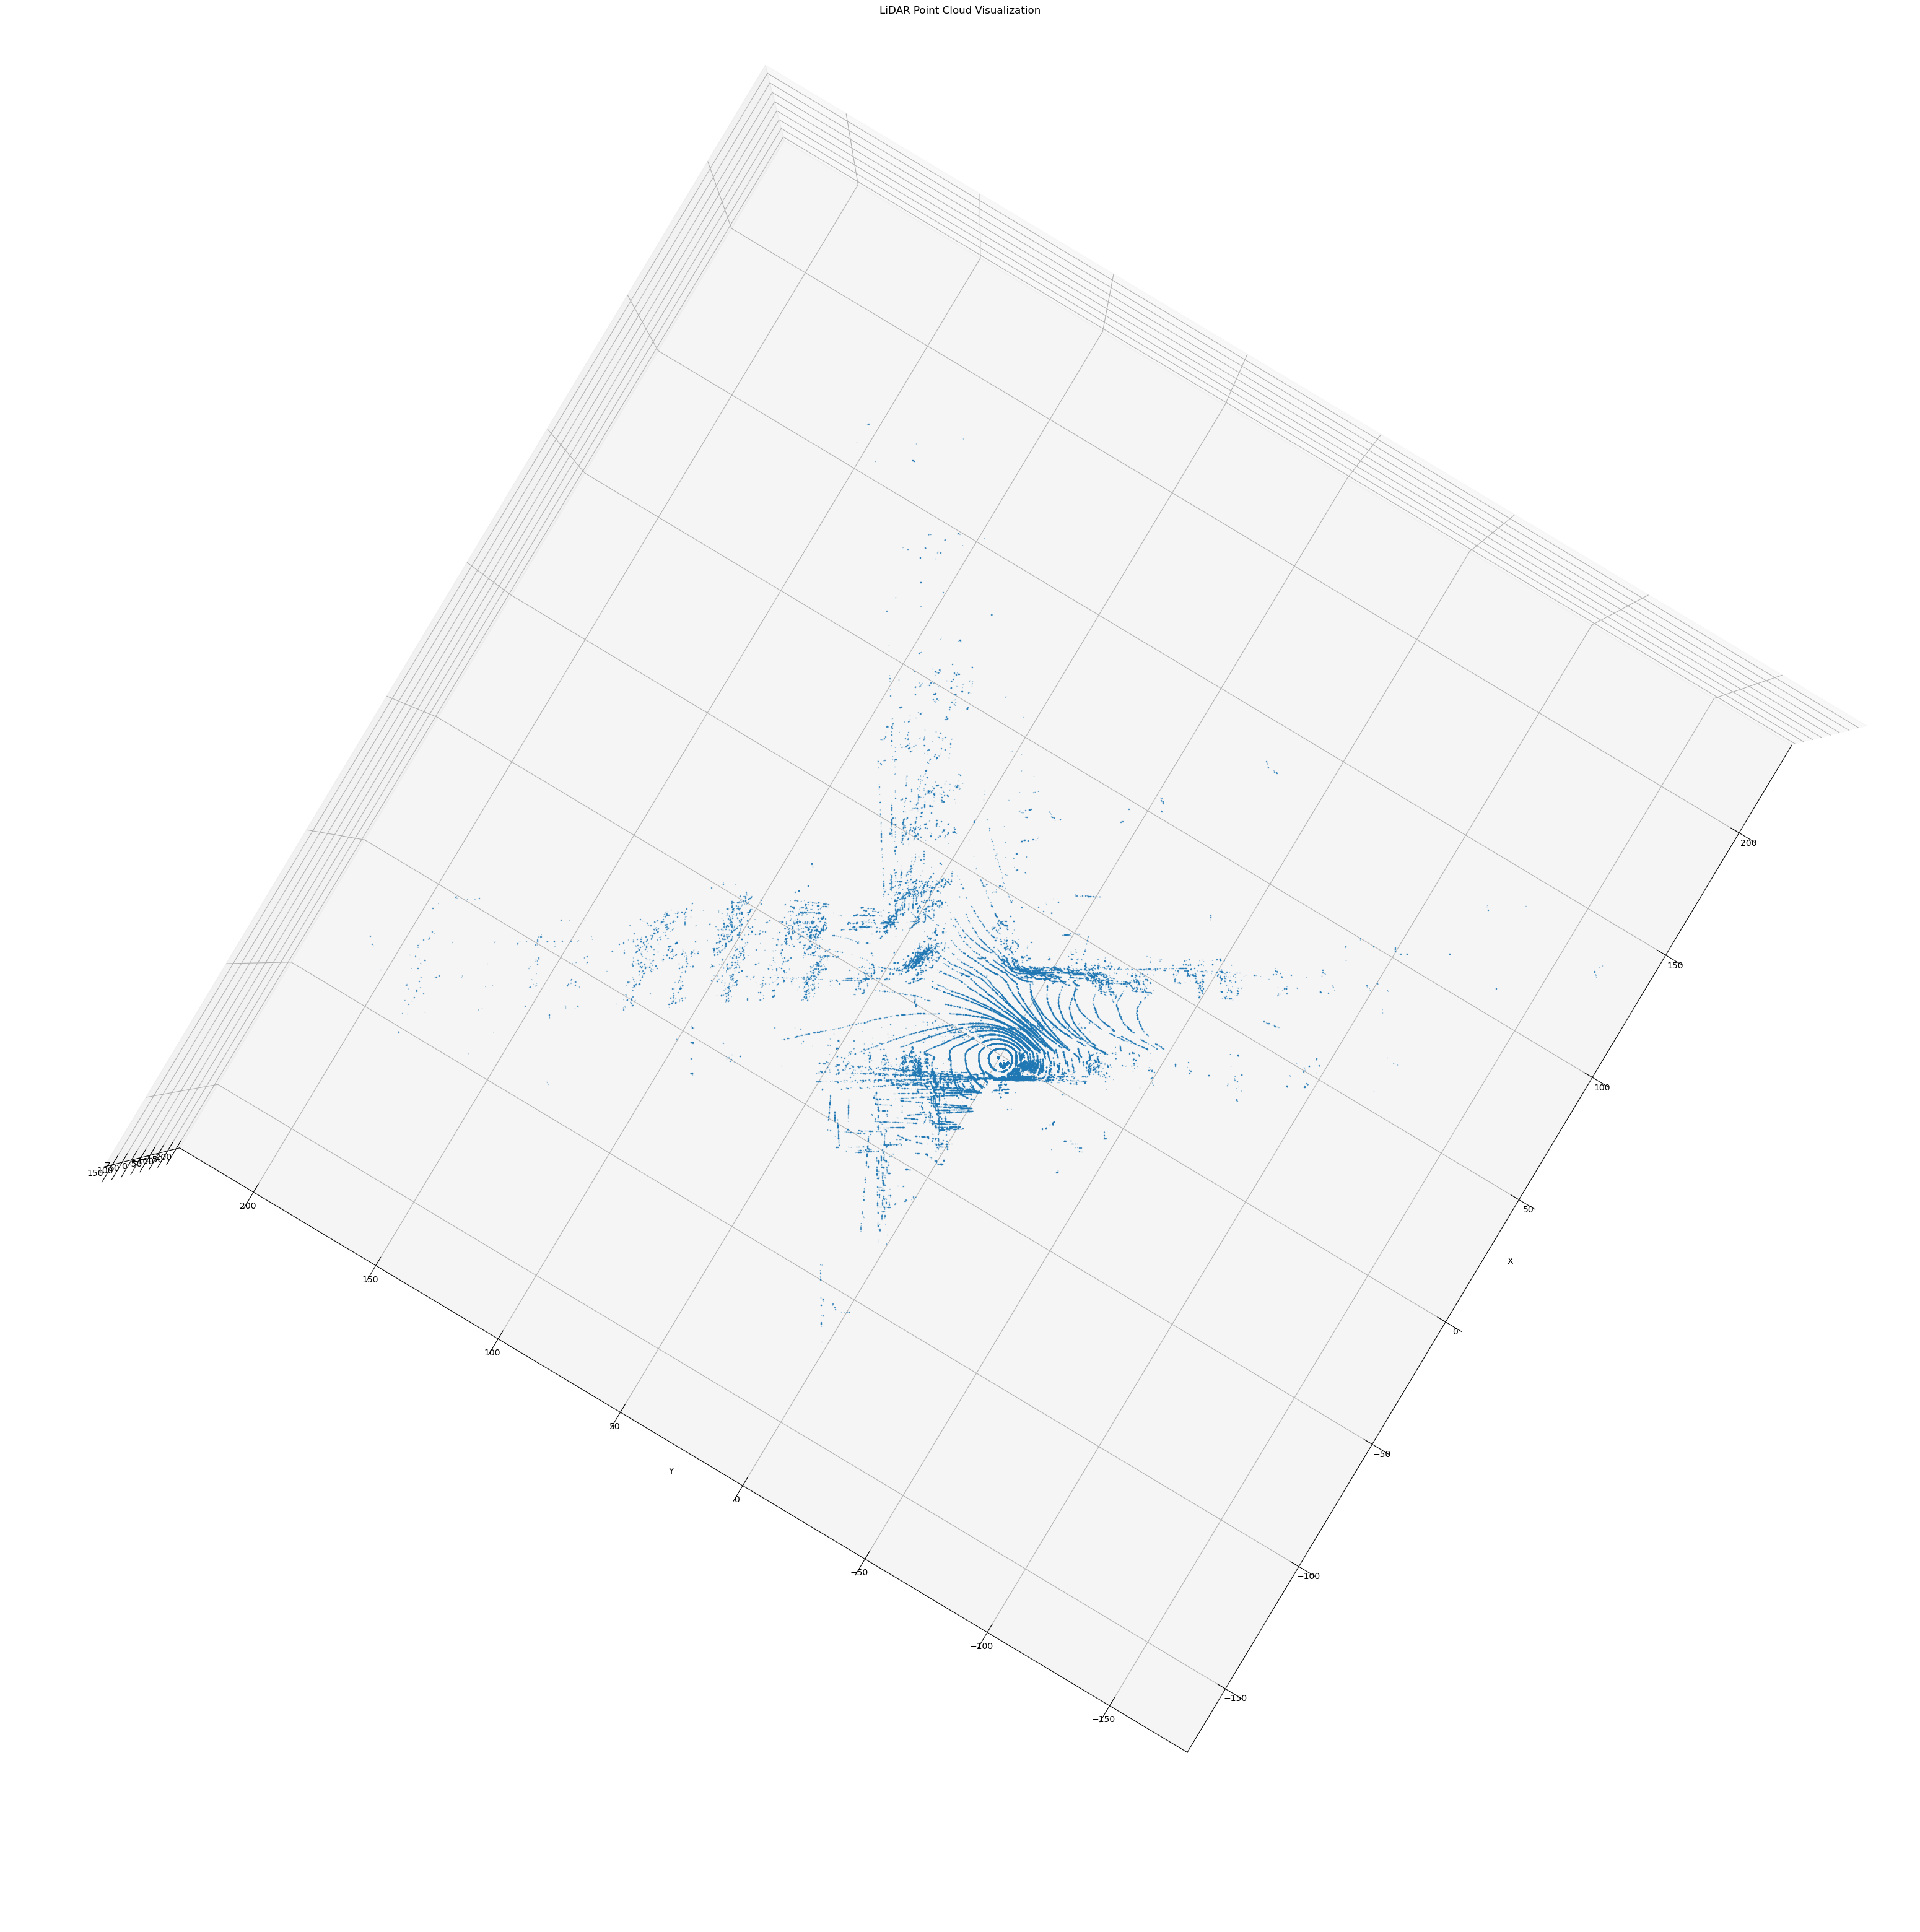

In [441]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot a subset if there are too many points
idx = np.random.choice(len(x_valid), size=100000, replace=False)
ax.scatter(x_valid[idx], y_valid[idx], z_valid[idx], s=0.1, marker=',')
# ax.scatter(x_valid, y_valid, z_valid, s=0.1)  # Adjust 's' for point size

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('LiDAR Point Cloud Visualization')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210)

# Fix aspect ratio
set_axes_equal(ax)

plt.show()

## Test filter on frame

## Run the inference time test

## Save filtered data for inference tests